In [1]:
from scipy.signal import find_peaks
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
import scipy.signal
from astropy import units as u
import nana
from scipy.interpolate import CubicSpline
import matplotlib.ticker as ticker
from matplotlib.patches import Ellipse
from math import cos, sin, radians
from matplotlib.collections import EllipseCollection
from astropy.table import Table
from astropy.io import ascii
import corner

In [2]:
def get_started(num_of_peaks, xs, ys): 
    """
    
    Identifies and returns the indices of the highest peaks in a given dataset.
    
    Args:
        num_of_peaks (int): The number of highest peaks to return.
        xs (numpy.ndarray): The x-axis values 
        ys (numpy.ndarray): The y-axis values

    Returns:
        numpy array: An array of indices corresponding to the highest peaks in `ys`.

    Bugs:
        `num_of_peaks` cannot be greater than the number of detected peaks
        `xs` or `ys` must be NumPy array

    
    """
    indxs, properties = find_peaks(ys)
    return indxs[np.argsort(-ys[indxs])[:num_of_peaks]]

def check_inputs(xs):
    """
    
    Checks whether the input array `xs` is sorted in ascending order.

    Args:
        xs (numpy.ndarray or list): The input array to check.

    Returns:
        bool: `True` if `xs` is sorted in ascending order, otherwise `False`.
    
    """
    for i in range(len(xs)-1):
        if xs[i] > xs[i+1]:
            print("check_inputs(): input xs is badly ordered. Use reorder_inputs to reorder")
            return False
    return True

def reorder_inputs(xs,ys):
    """
    
    Reorders the input arrays `xs` and `ys` in ascending order of `xs`.

    Args:
        xs (numpy.ndarray): The x-axis values 
        ys (numpy.ndarray): The y-axis values
        
    Returns:
        tuple of numpy arrays (sorted xs, sorted ys)

    Bugs:
        `xs` or `ys` must be NumPy array
        `xs` and `ys`must be same length
        
    """
    i = np.argsort(xs)
    return xs[i], ys[i]

#xlist is the teh index left to highest peak, highest peak, and the index right to teh highest peak
def design_matrix(xlist): 
    """
    
    Constructs a design matrix for quadratic curve fitting.

    Args:
        xs (numpy.ndarray): The x-axis values 

    Returns:
        3 x 3 design matrix of numpy arrays

    Bugs:
        xlist must be an numpy array

    Note:
        Note the factor of 0.5 that Hogg likes and no one else
        Also assumes xlist is ordered
    
    """
    return (np.vstack((xlist**0,xlist**1,0.5*xlist**2))).T

def fit_parabola(xs, ys, index):
    """

    Fits a quadratic function to three consecutive data points. Solves for coefficients (b,m,q) in the quadratic
    f(x) = b + m*x + (1/2) * q * x^2

    Args:
        xs (numpy.ndarray): The x-axis values 
        ys (numpy.ndarray): The y-axis values
        index (int): The index of peak
        

    Returns:
        tuple: (b, m, q)

    Bugs: 
        index-1` or `index+2` can't be out of bounds
        ``xs` or `ys` must be NumPy array
        
    
    """
    return np.linalg.solve(design_matrix(xs[index-1:index+2]), ys[index-1:index+2])

def refine_peak(xs, ys, index):
    """

    Refines the peak position using quadratic fit

    Args:
        xs (numpy.ndarray): The x-axis values 
        ys (numpy.ndarray): The y-axis values
        index (int): The index of peak
    
    Returns:
        3-tuple: (x position of refined peak, y position of refined peak, and second derivative (q))

    Bugs:
        Must be synchronized with the design matrix
        
        
    """
    b,m,q = fit_parabola(xs, ys, index)
    x_peak = -m / q
    return x_peak, 0.5 * q * (x_peak) ** 2 + m * (x_peak) + b, q
    
def refine_peaks(xs, ys, indices):
    """

    Refines the peak position for a set of indices using quadratic fit

    Args:
        xs (numpy.ndarray): The x-axis values 
        ys (numpy.ndarray): The y-axis values
        indices (numpy array): indices of the peaks (this should be the output of get_started()

    Returns:
        three  numpy arrays (array of refined x positions, array of refined y positions, and the second derivatives)
    

    """
    foo = lambda i: refine_peak(xs,ys,i)
    xs_refined, ys_refined, second_derivatives = zip(*list(map(foo,indices)))
    return np.array(xs_refined), np.array(ys_refined), np.array(second_derivatives)


def folding_freq(fs, ps, sampling_time, makeplots=False):
    """
    ##bugs:
    - assumes fs are ordered
    - global delta_f
    """
    fc_guess = 1. / sampling_time
    
    IA = fs < 0.5 * fc_guess
    fsA, psA = fs[IA], ps[IA]
    fsA,psA  = fsA[2:-2],  psA[2:-2]
    cs = CubicSpline(fs, ps, extrapolate=False)
    
    small, tiny = 20 * delta_f, 0.25 * delta_f
    fc_candidates = np.arange(fc_guess - small, fc_guess + small, tiny)
    foos_c = np.array([np.nansum(psA * cs(fc - fsA)) for fc in fc_candidates])
    fc_index = get_started(1,fc_candidates, foos_c)
    fc, _, _ = refine_peaks(fc_candidates, foos_c, fc_index)
    fc = fc[0]
    
    if makeplots:
        plt.plot(fc_candidates, foos_c)
        plt.axvline(fc_guess)
        plt.axvline(fc, color = 'red', alpha = 0.5)
        plt.title(fc)
        plt.show()

    
    return fc

def find_min_and_refine(xs,ys):
    indxs, properties = find_peaks(-ys)
    min_index =  indxs[np.argsort(ys[indxs])[:1]]
    refined_x, refined_y, second_derivative = refine_peaks(xs, ys, min_index)
    return refined_x[0], refined_y[0]

def get_started_filtered(num_of_peaks, xs, ys): 
    '''
    ##bugs:
    - realizes on global variable f_avoid
    '''
    indxs, properties = find_peaks(ys)
    indices = indxs[np.argsort(-ys[indxs])]

    filtered = []
    for index in indices:
        if all(abs(xs[index] - xs[i]) >= (f_avoid) for i in filtered):
            filtered.append(index)
            if(len(filtered) >= num_of_peaks):
                break
    return np.array(filtered)


In [3]:
search_result = lk.search_lightcurve('KIC 5202905', mission='Kepler')
lc_collection = search_result.download_all()

In [4]:
lc = lc_collection.stitch()
total_observation_time = (lc.time[-1] - lc.time[0]).value
delta_f = (1/total_observation_time) 
sampling_time= np.median(np.diff(lc.time.value))

In [5]:
#this is a magic number
f_avoid = 3.5 / 372.5 #372.5 is kepler orbital period, 

In [6]:
f_max = (2 / (sampling_time))
f_min = delta_f/3
frequency_grid_full = np.arange(f_min, f_max, f_min)/(u.day)

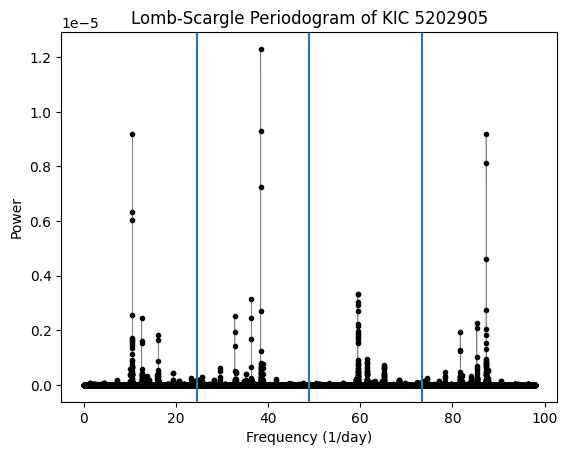

In [7]:
pg_full = lc.to_periodogram(
    method='lombscargle',
    normalization='psd',
    frequency=frequency_grid_full
)

power_full = pg_full.power.value
freq_full = pg_full.frequency.to(1/u.day).value 

plt.plot(freq_full, power_full,'k.')
plt.plot(freq_full, power_full,'k-', lw = 0.5, alpha = 0.5)
plt.xlabel("Frequency (1/day)")
plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram of KIC 5202905")
plt.axvline(1/sampling_time)
plt.axvline(1/(2*sampling_time))
plt.axvline(3/(2*sampling_time))
plt.show() 

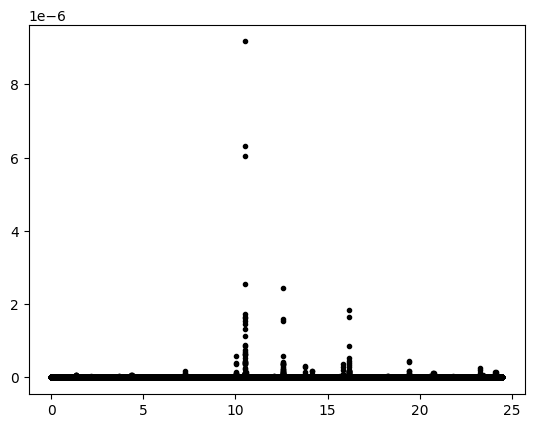

In [8]:
frequency_grid = np.arange(f_min, f_max / 4, f_min) / (u.day)

pg = lc.to_periodogram(
    method='lombscargle',
    normalization='psd',
    frequency=frequency_grid
)

power = pg.power.value
freq = pg.frequency.to(1/u.day).value 

plt.plot(freq, power, 'k.')

In [9]:
t = lc.time.value
flux = lc.flux.value
sigma = lc.flux_err.value

t_clean = np.ma.filled(t, np.nan)
flux_clean = np.ma.filled(flux, np.nan)
sigma_clean = np.ma.filled(sigma, np.nan)

mask = np.isfinite(t_clean) & np.isfinite(flux_clean) & np.isfinite(sigma_clean)

lc = lc[mask]
t_fit = t_clean[mask]
flux_fit = flux_clean[mask]
sigma_fit = sigma_clean[mask]

In [10]:
lc_exptime = (6.52 * 270) / (60 * 60 * 24) #days, see Kepler Data Processing Handbook, Section 3.1
weight_fit = 1 / sigma_fit**2

def integral_design_matrix(ts, om, T):
    """
    ##bugs:
    - assumes all data points have the same exposure time, `T`
    - not numerically stable when `om * T` is small
    """
    return np.vstack([
        np.ones_like(ts),
        (+ np.sin(om * (ts + T/2)) - np.sin(om * (ts - T/2))) / (om * T),
        (- np.cos(om * (ts + T/2)) + np.cos(om * (ts - T/2))) / (om * T)
    ]).T

def weighted_least_squares(A, b, weights):
    ATA = A.T @ (A * weights[:, np.newaxis])
    ATb = A.T @ (b * weights)
    return A @ np.linalg.solve(ATA, ATb)

def weighted_least_squares_new(A, b, weights):
    ATA = A.T @ (A * weights[:, np.newaxis])
    ATb = A.T @ (b * weights)
    trace = np.trace(ATA)
    det = np.linalg.det(ATA)
    return np.linalg.solve(ATA, ATb), ATA

def integral_chi_squared(om, ts, ys, ws, T):
    A = integral_design_matrix(ts, om, T)
    return np.sum(ws * (ys - weighted_least_squares(A, ys, ws))**2)

In [11]:
fc = folding_freq(freq_full, power_full, sampling_time, False)
indices = get_started_filtered(12, freq, power)
refined_freq, refined_power, second_derivatives = refine_peaks(freq, power, indices)
print(refined_freq)

[10.54113514 12.56701919 16.17299573 10.05192849 19.44253463 15.84963682
 13.77654431 23.28943326 14.18094186  7.26434652 24.09719219 24.13377704]


In [12]:
#find the correponding A,B,C region for each peak
#finding which region the peak truly lies in
#output bestchisquared
#use np.likzeros
#look over a,b,c loop over dictionary, similar to cases, dictionary with three elements
def region_and_freq(indices, folding_freq):
    
    regions, best_freqs, best_chi2s = [], [], []

    for i in range(len(indices)):
        fas, __, __ = refine_peaks(freq, power, indices)
        A, B, C = fas, folding_freq-fas, folding_freq+fas
        
        fine_freqsA = np.arange(A[i] - 5 * f_min, A[i] + 5 * f_min, 0.2 * f_min)  
        chi2_fineA = np.array([integral_chi_squared(2. * np.pi * f, t_fit, flux_fit, weight_fit, lc_exptime) for f in fine_freqsA])
        best_freqA, best_chi2A = find_min_and_refine(fine_freqsA,chi2_fineA)
    
        fine_freqsB = np.arange(B[i]- 5 * f_min, B[i] + 5 * f_min, 0.2 * f_min)  
        chi2_fineB = np.array([integral_chi_squared(2. * np.pi * f, t_fit, flux_fit, weight_fit, lc_exptime) for f in fine_freqsB])
        best_freqB, best_chi2B = find_min_and_refine(fine_freqsB,chi2_fineB)
    
        fine_freqsC = np.arange(C[i] - 5 * f_min, C[i] + 5 * f_min, 0.2 * f_min)  
        chi2_fineC = np.array([integral_chi_squared(2. * np.pi * f, t_fit, flux_fit, weight_fit, lc_exptime) for f in fine_freqsC])
        best_freqC, best_chi2C = find_min_and_refine(fine_freqsC,chi2_fineC)
        
        #print(best_chi2A, best_chi2B, best_chi2C)

        if (best_chi2A <= best_chi2B and best_chi2A <= best_chi2C):
            regions.append("A")
            best_freqs.append(best_freqA)
            best_chi2s.append(best_chi2A)
            
        elif (best_chi2B < best_chi2A and best_chi2B < best_chi2C):
            #print("here")
            regions.append("B")
            best_freqs.append(best_freqB)
            best_chi2s.append(best_chi2B)
            
        elif (best_chi2C < best_chi2A and best_chi2C < best_chi2B):
            #print("herec")
            regions.append("C")
            best_freqs.append(best_freqC)
            best_chi2s.append(best_chi2C)


    return(regions, best_freqs, best_chi2s)

regions, freqs, chi2s = region_and_freq(indices, fc)

In [1]:
def check_coherence(ts, ys, weights, oms):
    '''assumes a lot of thing about the data
    '''

    
    a_early, a_late, b_early, b_late, invvars = [], [], [], [], []
    
    ts_median = np.median(ts)
    
    cases = [(ts < ts_median, "early"),
             (ts > ts_median, "late")]
    
    for om in oms:
        
        for I, name in cases:
            A = integral_design_matrix(ts[I], om, lc_exptime)
            pars, ___ = weighted_least_squares_new(A, ys[I], weights[I])
            a,b = pars[1], pars[2]
            
            if name == "early":
                a_early.append(pars[1])
                b_early.append(pars[2])
            elif name == "late":
                a_late.append(pars[1])
                b_late.append(pars[2])

    return a_early, a_late, b_early, b_late
            
        

In [14]:
oms = np.array([(f * 2 * np.pi) for f in freqs])

a_early, a_late, b_early, b_late = check_coherence(t_fit, flux_fit, weight_fit, oms)


In [15]:
def change_in_phase_and_amp(a_early, a_late, b_early, b_late, ts):

    rates_of_phases = []
    rates_of_amps = []
    ts_median = np.median(ts)
    delta_t = np.median(ts[ts>ts_median]) - np.median(ts[ts < ts_median])

    

    for a_earl_grey, a_latte, b_earl_grey, b_latte in zip(a_early, a_late, b_early, b_late):
    

        delta_r = [a_latte - a_earl_grey, b_latte - b_earl_grey]
        vector_r = [0.5 * (a_latte + a_earl_grey), 0.5 * (b_latte + b_earl_grey)]

        cross_z = delta_r[0] * vector_r[1] - delta_r[1] * vector_r[0]
        phase = (1 / delta_t) * (cross_z / np.dot(vector_r, vector_r))
        rates_of_phases.append(phase)
        
        amplitude = (1/(delta_t)) * (np.dot(delta_r, vector_r) / np.dot(vector_r, vector_r))
        rates_of_amps.append(amplitude)

    return (rates_of_phases, rates_of_amps)


In [16]:
F1_rate_of_phase, F2_rate_of_amp = change_in_phase_and_amp(a_early, a_late, b_early, b_late, t_fit)

In [17]:
#statistics to give hogg for each freq
#the freq, the region
#the corresponding frequency in region "A"
#t, F1 values
print("These are top 12 frequecies:", freqs)
print("These are the regions:", regions)
print("Correspoding freq in a regions:", freq)
print("rate of chaneg of phases:", F1_rate_of_phase)
print("rate of change of amplitudes", F2_rate_of_amp)

These are top 12 frequecies: [np.float64(38.397935597705626), np.float64(36.372056856145484), np.float64(32.766075093585535), np.float64(38.8871452379099), np.float64(29.496546029712693), np.float64(33.08945009795461), np.float64(35.16254027442285), np.float64(25.649648822423835), np.float64(14.180936357036815), np.float64(41.67473039341861), np.float64(24.84188661745401), np.float64(24.805303401761634)]
These are the regions: ['B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'A', 'B', 'B', 'B']
Correspoding freq in a regions: [2.26686086e-04 4.53372172e-04 6.80058257e-04 ... 2.44689495e+01
 2.44691762e+01 2.44694028e+01]
rate of chaneg of phases: [np.float64(-2.643738763475577e-05), np.float64(2.193756011014407e-05), np.float64(6.8409178482580515e-06), np.float64(-2.430815764425696e-05), np.float64(-7.648863166395443e-06), np.float64(2.4154931760242347e-06), np.float64(1.695781171416043e-05), np.float64(-1.930390223182324e-05), np.float64(1.8469022091666844e-06), np.float64(6.805248971656252e-

In [18]:
print(type(freq))
print(len(freq))
#print(len(refined_freq))

<class 'numpy.ndarray'>
107944


In [19]:
#data = Table()
'''
data['top_12_freqs'] = freqs
data['regions'] = regions
data['corresponding_freq_in_region_A'] = refined_freq
data['rate_of_change_of_phase'] = F1_rate_of_phase
data['rate_of_change_of_amplitude'] = F2_rate_of_amp

# Write to CSV with custom formatting
ascii.write(
    data,
    'top12_in_KIC_5202905.csv',
    overwrite=True,
    format="csv",
    formats={
        "top_12_freqs": "{:.10f}",
        "corresponding_freq_in_region_A": "{:.10f}",
        "rate_of_change_of_phase": "{:.5e}",
        "rate_of_change_of_amplitude": "{:.5e}"
    }
)

print(type(freqs))# '''

'\ndata[\'top_12_freqs\'] = freqs\ndata[\'regions\'] = regions\ndata[\'corresponding_freq_in_region_A\'] = refined_freq\ndata[\'rate_of_change_of_phase\'] = F1_rate_of_phase\ndata[\'rate_of_change_of_amplitude\'] = F2_rate_of_amp\n\n# Write to CSV with custom formatting\nascii.write(\n    data,\n    \'top12_in_KIC_5202905.csv\',\n    overwrite=True,\n    format="csv",\n    formats={\n        "top_12_freqs": "{:.10f}",\n        "corresponding_freq_in_region_A": "{:.10f}",\n        "rate_of_change_of_phase": "{:.5e}",\n        "rate_of_change_of_amplitude": "{:.5e}"\n    }\n)\n\nprint(type(freqs))# '

In [20]:
print(delta_f)

0.0006800582572566702


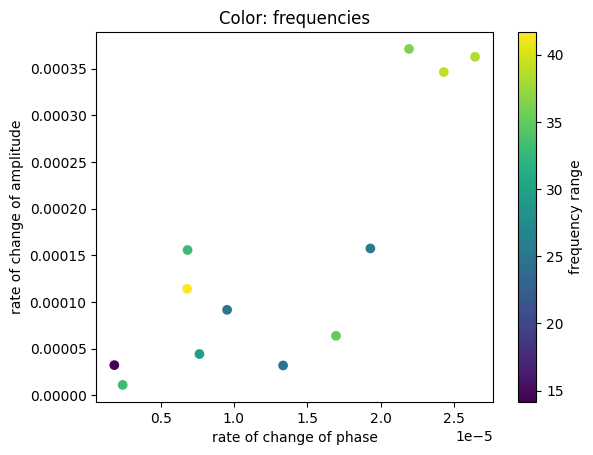

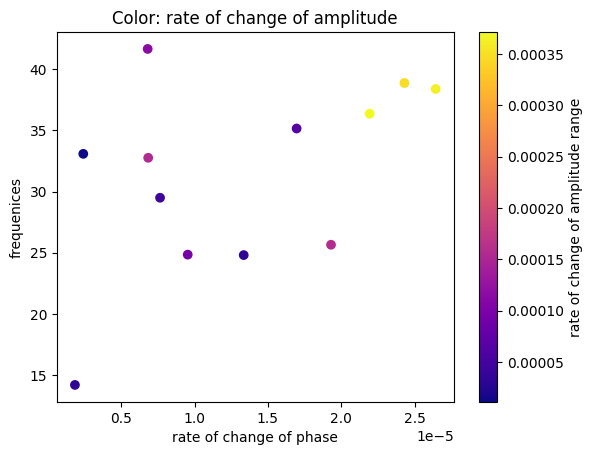

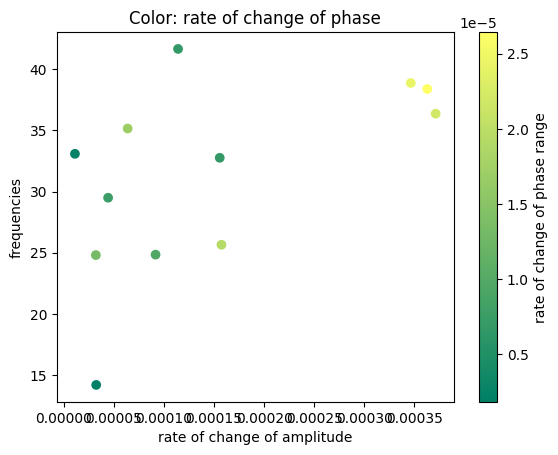

In [21]:
F1_rate_of_phase = np.abs(F1_rate_of_phase)
F2_rate_of_amp = np.abs(F2_rate_of_amp)


# Plot 1: F1_rate_of_phase vs F2_rate_of_amp, color by freqs
plt.figure()
plt.scatter(F1_rate_of_phase, F2_rate_of_amp, c=freqs, cmap='viridis')
plt.xlabel("rate of change of phase")
plt.ylabel("rate of change of amplitude")
plt.title("Color: frequencies")
plt.colorbar(label="frequency range")
plt.show()

# Plot 2: F1_rate_of_phase vs freqs, color by F2_rate_of_amp
plt.figure()
plt.scatter(F1_rate_of_phase, freqs, c=F2_rate_of_amp, cmap='plasma')
plt.xlabel("rate of change of phase")
plt.ylabel("frequenices")
plt.title("Color: rate of change of amplitude")
plt.colorbar(label="rate of change of amplitude range")
plt.show()

# Plot 3: F2_rate_of_amp vs freqs, color by F1_rate_of_phase
plt.figure()
plt.scatter(F2_rate_of_amp, freqs, c=F1_rate_of_phase, cmap='summer')
plt.xlabel("rate of change of amplitude")
plt.ylabel("frequencies")
plt.title("Color: rate of change of phase")
plt.colorbar(label="rate of change of phase range")
plt.show()

In [22]:
def sharpness(second_derivatives, y_news):
    sharps = []
    for second_derivative, y_new in zip(second_derivatives, y_news):
        sharpness = (-second_derivative/y_new)**(1/2)
        sharps.append(sharpness)
    return sharps

In [23]:
sharpnesses = sharpness(second_derivatives, refined_power)

In [24]:
np.max(sharpnesses)

np.float64(3724.2531330558263)

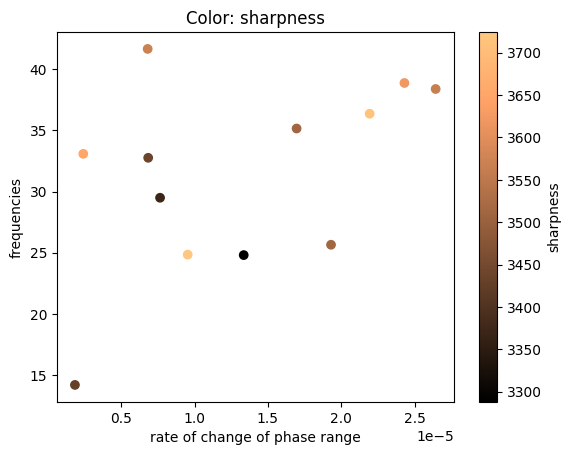

In [25]:
#using sharpness

plt.figure()
plt.scatter(F1_rate_of_phase, freqs, c=sharpnesses, cmap='copper')
plt.xlabel("rate of change of phase range")
plt.ylabel("frequencies")
plt.title("Color: sharpness")
plt.colorbar(label="sharpness")
plt.show()

In [26]:
data = np.vstack([freqs, F1_rate_of_phase, F2_rate_of_amp, sharpnesses])


In [27]:
#compute delta-chi-squared for each mode

#instructions from hogg
#a0 = np.sum(invvar * flux) / np.sum(invvar)
#ull_chisq = np.sum(invvar * (flux - a0) ** 2)
#And then you subtract from this the best chisq at the best refined frequency.

def null_chi_squared(ts, ys, weights):
    
    a0 = np.sum(weights * ys) / np.sum(weights)
    null_chisq = np.sum(weights * (ys - a0) ** 2)
    return null_chisq


        

In [28]:
delta_chi2s = null_chi_squared(t_fit, flux_fit, weight_fit) - chi2s
print(delta_chi2s)

[945004.         243990.5        195206.5         59014.5
  48133.          38249.0625      33401.875       25674.625
  15006.12890625  17167.875       14251.3046875   15019.9296875 ]


In [29]:
###new stats to send to hogg
##the chisquared refined frequencies
##the region
##corresponding frequency in region A
##sharpness
##delta chi squared
##the F1 value rate of change of phase, dphi/dt
##the F2 value, rate of change of amplitude, dA/dt

chi_squared_refined_freqs = freqs
regions =regions
freqs_in_A = refined_freq
sharpnesses = sharpnesses
dphi_dt = F1_rate_of_phase
dA_dt = F2_rate_of_amp

data = Table()


data['modes'] = freqs
data['regions'] = regions
data['corresponding_freq_in_region_A'] = refined_freq
data['sharpness'] = sharpnesses
data['delta_chi_squares'] = delta_chi2s
data['rate_of_change_of_phase'] = dphi_dt
data['rate_of_change_of_amplitude'] = dA_dt

# Write to CSV with custom formatting
ascii.write(
    data,
    'new_stats_for_KIC_5202905.csv',
    overwrite=True,
    format="csv",
    formats={
        "modes": "{:.10f}",
        "corresponding_freq_in_region_A": "{:.5f}",
        "sharpness": "{:.7e}",
        "delta_chi_squares": "{:.7e}",
        "rate_of_change_of_phase": "{:.7e}",
        "rate_of_change_of_amplitude": "{:.7e}"
    }
)


In [30]:
print(data[0])

      modes        regions corresponding_freq_in_region_A     sharpness      delta_chi_squares rate_of_change_of_phase rate_of_change_of_amplitude
------------------ ------- ------------------------------ ------------------ ----------------- ----------------------- ---------------------------
38.397935597705626       B             10.541135137952823 3563.0485693467685          945004.0   2.643738763475577e-05      0.00036282322032178286


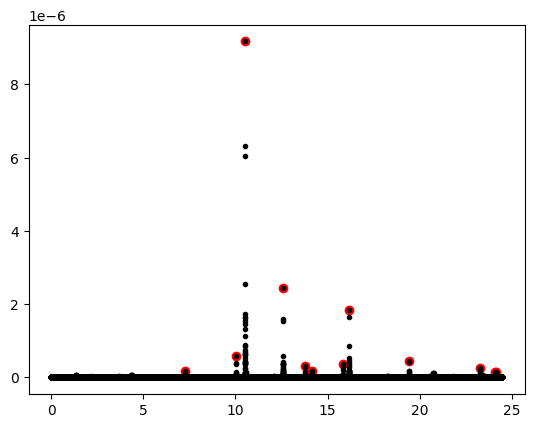

In [31]:
plt.plot(freq, power, 'k.')
plt.scatter(refined_freq, power[indices], color='r', marker='o')

In [32]:
print(freq[indices], power[indices])

[10.54112967 12.56702322 16.17291879 10.0519411  19.44263889 15.84966443
 13.77662018 23.28950176 14.18102815  7.2643823  24.09718429 24.13368075] [9.17365606e-06 2.44319907e-06 1.83545018e-06 5.78189455e-07
 4.43235113e-07 3.78646797e-07 3.10311267e-07 2.47101294e-07
 1.84483206e-07 1.66497541e-07 1.42439766e-07 1.37118914e-07]


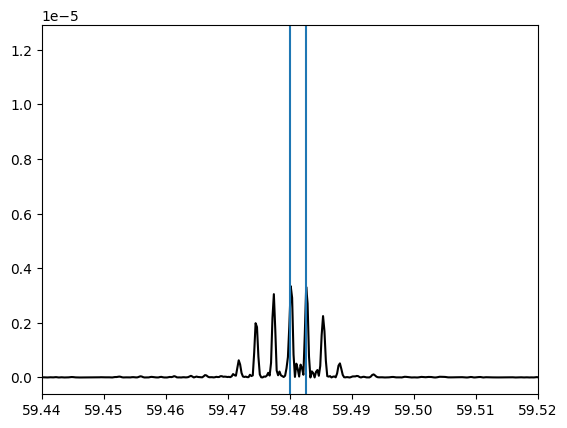

In [33]:
plt.plot(freq_full, power_full, 'k-')
plt.scatter(freqs, refined_power, color='r', marker='o')
#plt.xlim(38.392, 38.44)
plt.xlim(59.44, 59.52)
plt.axvline(59.48)
plt.axvline(59.48 + 1 / 372.5)
#plt.xlim(24.469500173919045, 48.93900034783809)
#plt.xlim(48.93900034783809, 73.40850052175713)

In [34]:
print(3/(2*sampling_time))

73.40850052175713


In [35]:
print(1/sampling_time)

48.93900034783809


In [36]:
print(refined_freq)

[10.54113514 12.56701919 16.17299573 10.05192849 19.44253463 15.84963682
 13.77654431 23.28943326 14.18094186  7.26434652 24.09719219 24.13377704]


In [37]:
print(freqs)

[np.float64(38.397935597705626), np.float64(36.372056856145484), np.float64(32.766075093585535), np.float64(38.8871452379099), np.float64(29.496546029712693), np.float64(33.08945009795461), np.float64(35.16254027442285), np.float64(25.649648822423835), np.float64(14.180936357036815), np.float64(41.67473039341861), np.float64(24.84188661745401), np.float64(24.805303401761634)]


In [38]:
print(freqs[0])

38.397935597705626


In [39]:
print(freqs[6])

35.16254027442285


In [40]:
print(refined_freq[0], refined_freq[6])
freqs_check = [refined_freq[0], refined_freq[6]]
powers_check = [refined_power[0], refined_power[6]]

10.541135137952823 13.776544307235566


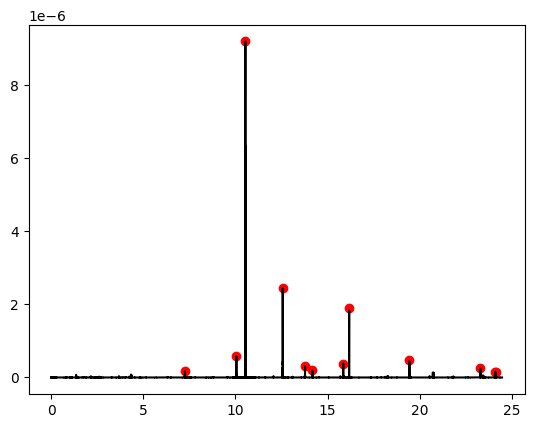

In [41]:
plt.plot(freq, power, 'k-')
#plt.xlim(10.52, 10.56)
plt.scatter(refined_freq, refined_power, color='r', marker='o')


In [42]:
print(power[indices])

[9.17365606e-06 2.44319907e-06 1.83545018e-06 5.78189455e-07
 4.43235113e-07 3.78646797e-07 3.10311267e-07 2.47101294e-07
 1.84483206e-07 1.66497541e-07 1.42439766e-07 1.37118914e-07]


In [43]:
freqs

[np.float64(38.397935597705626),
 np.float64(36.372056856145484),
 np.float64(32.766075093585535),
 np.float64(38.8871452379099),
 np.float64(29.496546029712693),
 np.float64(33.08945009795461),
 np.float64(35.16254027442285),
 np.float64(25.649648822423835),
 np.float64(14.180936357036815),
 np.float64(41.67473039341861),
 np.float64(24.84188661745401),
 np.float64(24.805303401761634)]

In [44]:
1/365

0.0027397260273972603

In [45]:
freqs[0]-freqs[6]

np.float64(3.2353953232827735)

In [46]:
##pipeline we're trying now
#find 12 peaks im region A
#for each peak use 

12


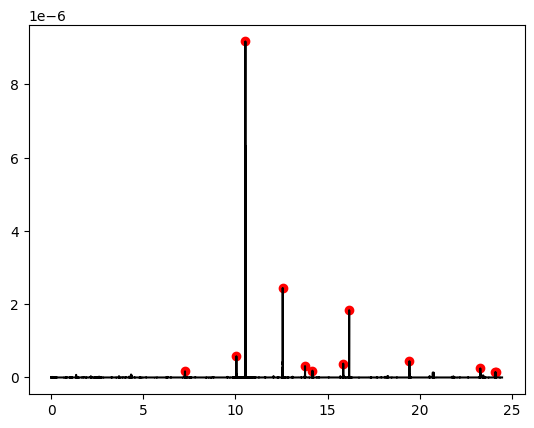

In [47]:
filters = get_started_filtered(12, freq, power)

plt.plot(freq, power, 'k-')
#plt.xlim(24, 24.2)
#plt.ylim(-1e-8, 2e-7)
plt.scatter(freq[filters], power[filters], color = 'r', marker = 'o')
print(len(filters))

In [48]:
print(refined_freq)

[10.54113514 12.56701919 16.17299573 10.05192849 19.44253463 15.84963682
 13.77654431 23.28943326 14.18094186  7.26434652 24.09719219 24.13377704]


In [49]:
np.diff(refined_freq)

array([ 2.02588405,  3.60597654, -6.12106724,  9.39060615, -3.59289782,
       -2.07309251,  9.51288895, -9.1084914 , -6.91659534, 16.83284567,
        0.03658486])

In [ ]:
indices = find_filtered_peaks(12, freq, power)